Here we will examine a simple orbital dynamics problem with Poynting Robertson drag in order to characterize the slimplectic_GGL integrator. The Lagrangian for a central gravitional potential (with mass $M_\odot$ is given by
$$ L = \frac{1}{2} m \dot{\mathbf q}^2 + (1-\beta)\frac{GM_{\odot}m}{r}$$
with nonconservative potential given by (up to terms linear in $v/c$)
$$ K = -\frac{\beta G M m }{c r_+^2} \left[\left(\delta_{ij} + \frac{q_{i+} q_{j+}}{r_+^2}\right)\dot{q}_+^i q_-^j\right] = -\frac{\beta G M_\odot m }{c r_+^2} \left[\dot{{\mathbf q}}_+ \cdot {\mathbf q}_- + \frac{1}{r_+^2}(\dot{{\mathbf q}}_+ \cdot {\mathbf q}_+)({\mathbf q}_+ \cdot {\mathbf q}_-)\right]$$
where 
$$\beta \simeq \frac{3L_\odot}{8\pi c \rho G M_\odot d} \simeq 0.0576906 \left(\frac{\rho}{2\, {\rm g}\,{\rm cm}^{-3}} \right)^{-1} \left(\frac{d}{10^{-3} {\rm cm}} \right)^{-1}$$
here $L_\odot$ is the sun's luminosity, $c$ is the speed of light, $\rho$ is the density of the dust grain, and $d$ is the diameter of the dust grain.


Here we will adopt Cartesian coordinates as our dynamical variables, such that 
${\mathbf q} = x \hat{\mathbf x} + y \hat{\mathbf y}$, with $r = ({\mathbf q} \cdot {\mathbf q})^{1/2}$

In [6]:
%pylab inline
import numpy as np, matplotlib.pyplot as plt
import slimplectic
from sympy import init_printing
import orbit_util as Kep
init_printing()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [7]:
plot_path = './plots/'
%load_ext autoreload
%autoreload 2

In [8]:
pr2 = slimplectic.GalerkinGaussLobatto('t', ['x', 'y'], ['\\dot{x}', '\\dot{y}'])
pr4 = slimplectic.GalerkinGaussLobatto('t', ['x', 'y'], ['\\dot{x}', '\\dot{y}'])
pr6 = slimplectic.GalerkinGaussLobatto('t', ['x', 'y'], ['\\dot{x}', '\\dot{y}'])
rk2 = slimplectic.RungeKutta2()
rk4 = slimplectic.RungeKutta4()

In [9]:
G = 39.478758435 # In units of AU**3/(M_sun yr**2)
M_Sun = 1.0 # In solar masses
rho = 2.0
d = 5.0e-3
beta = 0.0576906*(2.0/rho)*(1.0e-3/d)
c = 63241.3 # In AU/yr

In [10]:
r = np.dot(pr2.q, pr2.q)**0.5
r_p2 = np.dot(pr2.qp, pr2.qp)

In [11]:
# Conservative Lagrangian (per unit dust mass)
L = 0.5*(np.dot(pr2.v, pr2.v)) #Kinetic term
L += (1.0 - beta)*G*M_Sun/r #Central Potential


In [12]:
#Nonconservative Potential (per unit dust mass)
K = np.dot(pr2.vp, pr2.qm)
K += np.dot(pr2.vp, pr2.qp)*np.dot(pr2.qp, pr2.qm)/(r_p2)
K *= -beta*G*M_Sun/(r_p2*c)

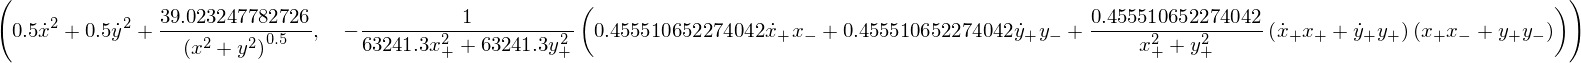

In [13]:
L, K

In [14]:
#Derivative function for Runge-Kutta integrators
def dydt(time, y):
    deriv = numpy.zeros(4)
    #print deriv
    [q_x, q_y, v_x, v_y] = y
    r = (q_x*q_x + q_y*q_y)**0.5
    deriv[0] = v_x
    deriv[1] = v_y
    deriv[2] = -(1. - beta)*G*M_Sun*q_x/(r*r*r) 
    deriv[2] -=(beta*G*M_Sun/(c*r*r))*(v_x + q_x*(q_x*v_x + q_y*v_y)/(r*r))
    deriv[3] = -(1. - beta)*G*M_Sun*q_y/(r*r*r)
    deriv[3] -=(beta*G*M_Sun/(c*r*r))*(v_y + q_y*(q_x*v_x + q_y*v_y)/(r*r))

    return deriv

In [15]:
pr2.discretize(L, K, 0, method='implicit')
pr4.discretize(L, K, 1, method='implicit')
pr6.discretize(L, K, 2, method='implicit')

In [16]:
#Initial Data, let's assume  
# a = 1.0, e = 0.0, i = 0, omega = 0, Omega = 0, M = 0
#
rvec, vvec = Kep.Calc_Cartesian(1.0, 0.2, 0.0, 0.0, 0.0, 0.0, (1.0-beta)*G*M_Sun)
rvec, vvec

(array([ 0.8,  0. ,  0. ]), array([-0.        ,  7.65080856,  0.        ]))

In [17]:
q0 = np.array([rvec[0], rvec[1]])
pi0 = np.array([vvec[0], vvec[1]]) #since we are assuming unit dust mass

In [18]:
q0, pi0

(array([ 0.8,  0. ]), array([-0.        ,  7.65080856]))

In [19]:
t_end = 6000
dt = 0.01
t = np.arange(0, t_end, dt)

In [20]:
q2, pi2 = pr2.integrate(q0, pi0, t)

/Users/dtsang/work/code/python/default/lib/python2.7/site-packages/scipy/optimize/minpack.py:227: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [21]:
q4, pi4 = pr4.integrate(q0, pi0, t)

In [22]:
q6, pi6 = pr6.integrate(q0, pi0, t)

In [23]:
qx_rk2, qy_rk2, vx_rk2, vy_rk2 =  rk2.integrate(np.array([rvec[0], rvec[1], vvec[0], vvec[1]]), t, dydt)
qx_rk4, qy_rk4, vx_rk4, vy_rk4 =  rk4.integrate(np.array([rvec[0], rvec[1], vvec[0], vvec[1]]), t, dydt)

In [24]:
def convert_to_3D(q, pi):
    r = column_stack((q[0,:], 
                      q[1,:], 
                      numpy.zeros(len(q[0,:]))))
    v = column_stack((pi[0,:], 
                      pi[1,:], 
                      numpy.zeros(len(pi[0,:]))))
    return r,v

def Energy(q, pi):
    E = 0.5*pi[0,:]*pi[0,:] + 0.5*pi[1,:]*pi[1,:]
    E -= (1.0-beta)*G*M_Sun/(q[0,:]*q[0,:] + q[1,:]*q[1,:])**0.5
    return E

In [25]:
r2, v2 = convert_to_3D(q2, pi2)
r4, v4 = convert_to_3D(q4, pi4)
r6, v6 = convert_to_3D(q6, pi6)
r_rk2 = column_stack((qx_rk2, qy_rk2, numpy.zeros(len(qx_rk2))))
v_rk2 = column_stack((vx_rk2, vy_rk2, numpy.zeros(len(vx_rk2))))
r_rk4 = column_stack((qx_rk4, qy_rk4, numpy.zeros(len(qx_rk4))))
v_rk4 = column_stack((vx_rk4, vy_rk4, numpy.zeros(len(vx_rk4))))

In [26]:
E2 = Energy(q2, pi2)
E4 = Energy(q4, pi4)
E6 = Energy(q6, pi6)
E_rk2 = Energy(np.array([qx_rk2, qy_rk2]), np.array([vx_rk2, vy_rk2]))
E_rk4 = Energy(np.array([qx_rk4, qy_rk4]), np.array([vx_rk4, vy_rk4]))


In [27]:
E_rk4

array([-19.51162389, -19.51163093, -19.51163803, ..., -21.81279165,
       -21.81279367, -21.8127957 ])

In [28]:
e2 = numpy.zeros(len(r2))
e4 = numpy.zeros(len(r4))
e6 = numpy.zeros(len(r6))
e_rk2 = numpy.zeros(len(r_rk2))
e_rk4 = numpy.zeros(len(r_rk4))

a2 = numpy.zeros(len(r2))
a4 = numpy.zeros(len(r4))
a6 = numpy.zeros(len(r6))
a_rk2 = numpy.zeros(len(r_rk2))
a_rk4 = numpy.zeros(len(r_rk4))

for i in range(len(e2)):
    e2[i] = Kep.Calc_e(r2[i], v2[i], (1.0-beta)*G*M_Sun)
    e4[i] = Kep.Calc_e(r4[i], v4[i], (1.0-beta)*G*M_Sun)
    e6[i] = Kep.Calc_e(r6[i], v6[i], (1.0-beta)*G*M_Sun)
    e_rk2[i] = Kep.Calc_e(r_rk2[i], v_rk2[i], (1.0-beta)*G*M_Sun)
    e_rk4[i] = Kep.Calc_e(r_rk4[i], v_rk4[i], (1.0-beta)*G*M_Sun)

    a2[i] = Kep.Calc_a(r2[i], v2[i], (1.0-beta)*G*M_Sun)
    a4[i] = Kep.Calc_a(r4[i], v4[i], (1.0-beta)*G*M_Sun)
    a6[i] = Kep.Calc_a(r6[i], v6[i], (1.0-beta)*G*M_Sun)
    a_rk2[i] = Kep.Calc_a(r_rk2[i], v_rk2[i], (1.0-beta)*G*M_Sun)
    a_rk4[i] = Kep.Calc_a(r_rk4[i], v_rk4[i], (1.0-beta)*G*M_Sun)
    

In [29]:
q2[0,:]

array([ 0.8       ,  0.79695131,  0.78784247, ...,  0.60932906,
        0.66175075,  0.70922502])

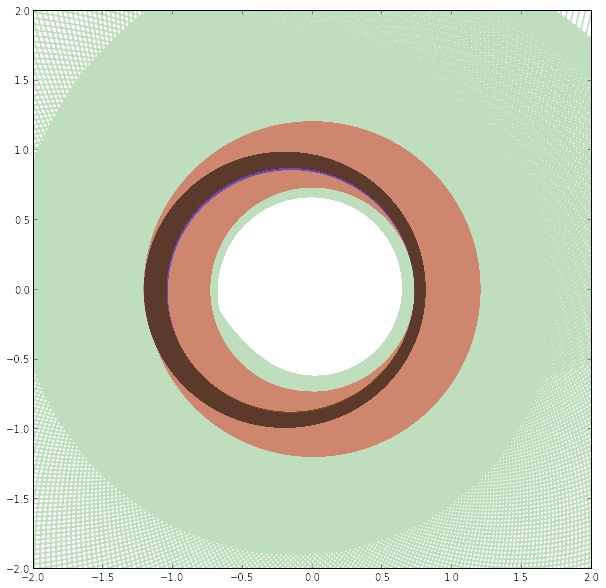

In [30]:
fig2 = pylab.figure(figsize=(10,10), dpi=500)
ax2 = fig2.add_subplot(1,1,1)
ax2.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.plot(qx_rk2[:], qy_rk2[:],
    linewidth=2.0, linestyle='-', alpha=.5,color='g')
ax2.plot(q2[0,:], q2[1,:],
    linewidth=2.0, linestyle='-', alpha=.5,color='r')
ax2.plot(qx_rk4[:], qy_rk4[:],
    linewidth=2.0, linestyle='-', alpha=.5,color='b')
ax2.plot(q4[0,:], q4[1,:],
    linewidth=2.0, linestyle='-', alpha=.5,color='orange')
ax2.plot(q6[0,:], q6[1,:],
    linewidth=2.0, linestyle='-', alpha=.5,color='black')


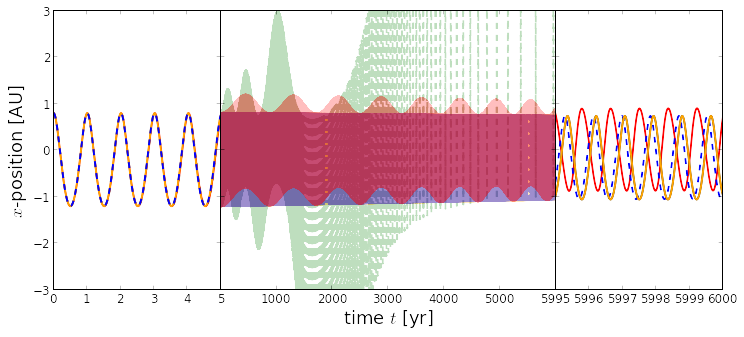

In [58]:
fig1 = pylab.figure(figsize=(12,5), dpi=800)
fig1.subplots_adjust(wspace=0)
ax1a = fig1.add_subplot(1,4,1)
ax1a.set_ylim(-3, 3)
ax1a.set_xlim(0,5)
ax1a.plot(t,qx_rk2,linewidth=2.0, linestyle='--', color='g', alpha=1,rasterized=True)
ax1a.plot(t,q2[0,:],linewidth=2.0, linestyle='-', color='red', alpha=1,rasterized=True)
ax1a.plot(t,q4[0,:],linewidth=2.0, linestyle='-', color='orange', alpha=1,rasterized=True)
ax1a.plot(t,qx_rk4,linewidth=2.0, linestyle='--', color='blue',alpha=1, rasterized=True)

ax1b = fig1.add_subplot(1,4,(2,3))
pylab.setp(ax1b.get_yticklabels(), visible=False)
ax1b.set_ylim(-3, 3)
ax1b.set_xlim(5,5995)
ax1b.plot(t,qx_rk2,linewidth=2.0, linestyle='--', color='g', alpha=.5, rasterized=True)
ax1b.plot(t,q4[0,:],linewidth=2.0, linestyle='-', color='orange',  alpha=.5,rasterized=True)
ax1b.plot(t,qx_rk4,linewidth=2.0, linestyle='--', color='blue',  alpha=.5,rasterized=True)
ax1b.plot(t,q2[0,:],linewidth=2.0, linestyle='-', color='red',  alpha=.5,rasterized=True)

ax1c = fig1.add_subplot(1,4,4)
pylab.setp(ax1c.get_yticklabels(), visible=False)
ax1c.set_ylim(-3, 3)
ax1c.set_xlim(5995,6000)
ax1c.get_xaxis().get_major_formatter().set_useOffset(False)
ax1c.plot(t,qx_rk2,linewidth=2.0, linestyle='--', color='g',alpha=1, rasterized=True)
ax1c.plot(t,q2[0,:],linewidth=2.0, linestyle='-', color='red', alpha=1,rasterized=True)
ax1c.plot(t,qx_rk4,linewidth=2.0, linestyle='--', color='blue', alpha=1,rasterized=True)
ax1c.plot(t,q6[0,:],linewidth=2.0, linestyle='-', color='black', alpha=1,rasterized=True)
ax1c.plot(t,q4[0,:],linewidth=2.0, linestyle='-', color='orange', alpha=1,rasterized=True)


ax1a.tick_params(axis='both', which='major', labelsize=12)
ax1b.tick_params(axis='both', which='major', labelsize=12)
ax1c.tick_params(axis='both', which='major', labelsize=12)


ax1b.set_xlabel('time $t$ [yr]', fontsize=18)
ax1a.set_ylabel('$x$-position [AU]', fontsize=18)

In [59]:
fig1.savefig(plot_path + "PRDrag_xLong.pdf", transparent=True,bbox_inches='tight', dpi=500)

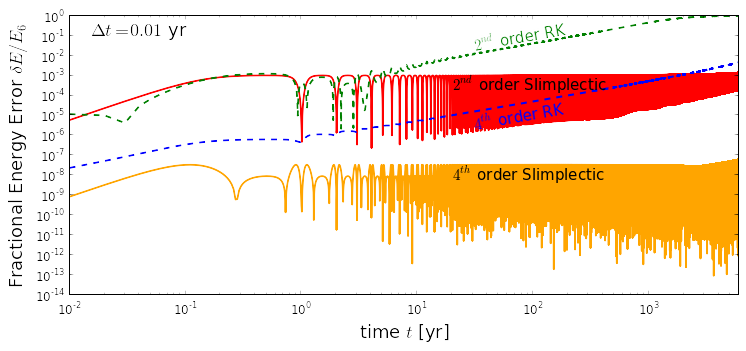

In [57]:
fig5 = plt.figure(figsize=(12,5), dpi=500)
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlim(0.01, 6000)
ax5.plot(t, np.abs((E2-E6)/E6),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)
ax5.plot(t, np.abs((E4-E6)/E6),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax5.plot(t, np.abs((E_rk2-E6)/E6),
    linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax5.plot(t, np.abs((E_rk4-E6)/E6),
    linewidth=2.0, linestyle='--', color='b', rasterized=True)
ax5.set_xlabel('time $t$ [yr]', fontsize=18)
ax5.set_ylabel('Fractional Energy Error $\delta E/E_6$', fontsize=18)
ax5.text(20, 1.8e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
ax5.text(20, 0.5e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax5.text(30, 1e-5, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation = 10)
ax5.text(30, 1e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)
ax5.text(0.015, 1e-1, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')

ax5.tick_params(axis='both', which='major', labelsize=12)



In [60]:
fig5.savefig(plot_path + "PRDrag_E_errorLong.pdf", transparent=True,bbox_inches='tight', dpi=500)

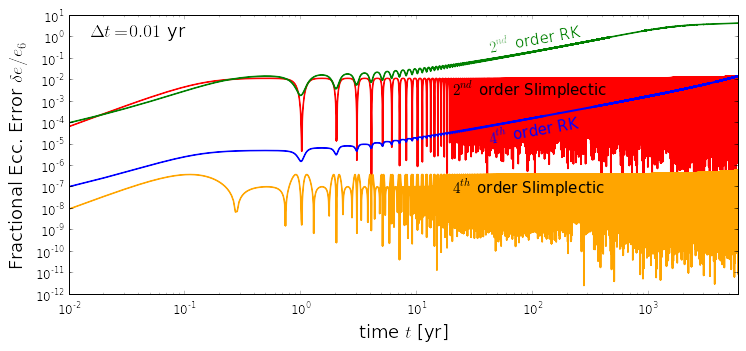

In [49]:
fig2 = plt.figure(figsize=(12,5), dpi=500)
ax2 = fig2.add_subplot(1,1,1)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.01, 6000)
ax2.plot(t, np.abs((e2-e6)/e6),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)
ax2.plot(t, np.abs((e4-e6)/e6),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax2.plot(t, np.abs((e_rk2-e6)/e6),
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax2.plot(t, np.abs((e_rk4-e6)/e6),
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax2.set_xlabel('time $t$ [yr]', fontsize=18)
ax2.set_ylabel('Fractional Ecc. Error $\delta e/e_6$', fontsize=18)
ax2.text(20, 1.8e-3, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
ax2.text(20, 0.5e-7, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax2.text(40, 0.5e-4, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation = 10)
ax2.text(40, 1e0, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.text(0.015, 1e0, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')


In [50]:
fig2.savefig(plot_path + "PRDrag_Ecc_errorLong.pdf", transparent=True,bbox_inches='tight', dpi=300)

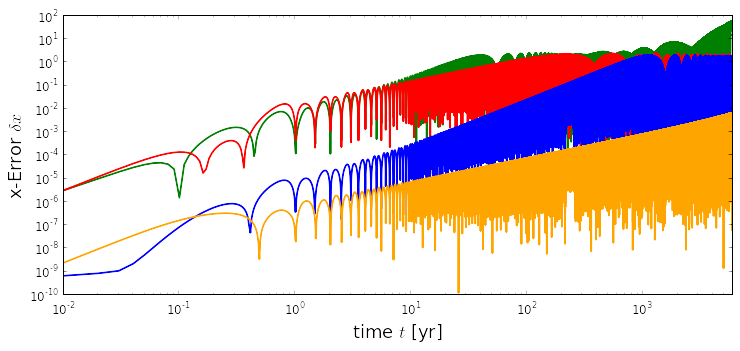

In [51]:
fig7 = plt.figure(figsize=(12,5), dpi=500)
ax7 = fig7.add_subplot(1,1,1)
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_xlim(0.01, 6000)
ax7.plot(t, np.abs(qx_rk2-q6[0,:]),
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax7.plot(t, np.abs(q2[0,:]-q6[0,:]),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)

ax7.plot(t, np.abs(qx_rk4-q6[0,:]),
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax7.plot(t, np.abs(q4[0,:]-q6[0,:]),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)

ax7.set_xlabel('time $t$ [yr]', fontsize=18)
ax7.set_ylabel('x-Error $\delta x$', fontsize=18)
#ax7.text(20, 1.8e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
#ax7.text(20, 0.5e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
#ax7.text(30, 1e-5, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation = 10)
#ax7.text(30, 1e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)
#ax7.text(0.015, 1e-1, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')

ax7.tick_params(axis='both', which='major', labelsize=12)


In [52]:
fig7.savefig(plot_path + "PRDrag_x_errorLong.pdf", transparent=True,bbox_inches='tight', dpi=300)

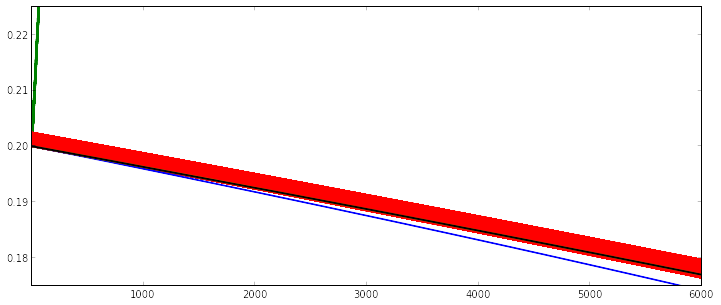

In [45]:
fig8 = plt.figure(figsize=(12,5), dpi=500)
ax8 = fig8.add_subplot(1,1,1)
ax8.set_ylim(0.175, 0.225)
ax8.set_xlim(0.01, 6000)

ax8.plot(t, e_rk2,
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax8.plot(t, e2,
    linewidth=2.0, linestyle='-', color='r', rasterized=True)

ax8.plot(t, e_rk4,
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax8.plot(t, e4,
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax8.plot(t, e6,
    linewidth=2.0, linestyle='-', color='black', rasterized=True)


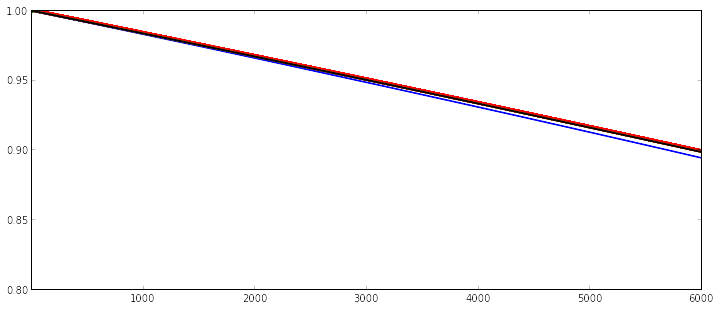

In [48]:
fig9 = plt.figure(figsize=(12,5), dpi=500)
ax9 = fig9.add_subplot(1,1,1)
ax9.set_ylim(0.8, 1.0)
ax9.set_xlim(0.01, 6000)

ax9.plot(t, a_rk2,
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax9.plot(t, a2,
    linewidth=2.0, linestyle='-', color='r', rasterized=True)

ax9.plot(t, a_rk4,
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax9.plot(t, a4,
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax9.plot(t, a6,
    linewidth=2.0, linestyle='-', color='black', rasterized=True)

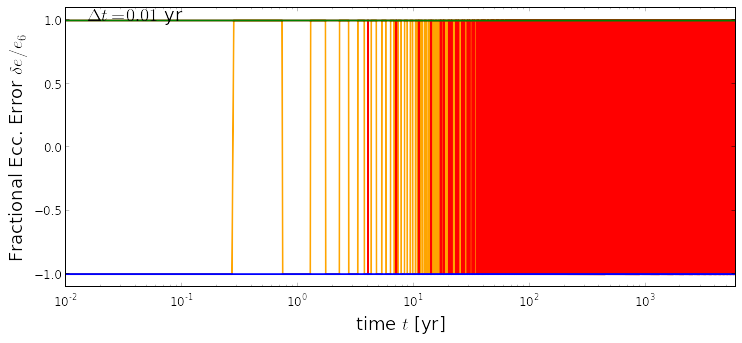

In [56]:
fig5 = plt.figure(figsize=(12,5), dpi=500)
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xscale('log')
ax5.set_ylim(-1.1, 1.1)
ax5.set_xlim(0.01, 6000)
ax5.plot(t, np.sign((e4-e6)),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax5.plot(t, np.sign((e2-e6)),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)
ax5.plot(t, np.sign((e_rk2-e6)),
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax5.plot(t, np.sign((e_rk4-e6)),
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax5.set_xlabel('time $t$ [yr]', fontsize=18)
ax5.set_ylabel('Fractional Ecc. Error $\delta e/e_6$', fontsize=18)
ax5.tick_params(axis='both', which='major', labelsize=12)
ax5.text(0.015, 1e0, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')
